In [1]:
from base import util
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.precision = 2
plt.rcParams['font.sans-serif'] = ['SimHei'] 

In [2]:
result=util.Local.get("""SELECT DATE(o.last_pay_time) AS stat_date,o.buyer_id,a.last_caller ,ROUND(last_age,0) AS age,o.good_name,o.order_price/100 AS order_price,o.app_id
FROM appshare.aps_biz_order o
         JOIN olap.user_active_stats a ON o.buyer_id = a.user_id
WHERE o.last_pay_time >= '2023-09-01' AND o.last_pay_time<='2023-09-14'
  AND o.order_pay_status = 1
AND o.order_price>0""",'all')
buyers_data=pd.DataFrame(result)
print(buyers_data.head())

    stat_date  buyer_id  last_caller   age   good_name order_price     app_id
0  2023-09-01  50424375         7010  12.0      7天故事会员      1.0000  idaddy001
1  2023-09-01  55090380         3003   5.0      7天故事会员      1.0000  idaddy001
2  2023-09-01  54163500         7010  15.0  连续包月（故事会员）      9.0000          0
3  2023-09-01  54163500         7010  15.0  连续包月（故事会员）      9.0000          0
4  2023-09-01  46147375         3010  13.0      7天故事会员      1.0000  idaddy001


In [3]:
result=util.Local.get("""SELECT DATE(o.last_pay_time) AS stat_date,o.buyer_id,a.last_caller ,ROUND(last_age,0) AS age,o.good_name,o.order_price/100 AS order_price,o.app_id
FROM appshare.aps_biz_order o
         JOIN olap.user_active_stats a ON o.buyer_id = a.user_id
WHERE o.last_pay_time >= '2022-09-01' AND o.last_pay_time<='2022-09-14'
  AND o.order_pay_status = 1
AND o.order_price>0""",'all')
buyers_data_old=pd.DataFrame(result)
print(buyers_data_old.head())

    stat_date  buyer_id  last_caller     age   good_name order_price  \
0  2022-09-01  35867735         2003  2022.0  连续包月（故事会员）     25.0000   
1  2022-09-01  47121615         3010     9.0     3个月故事会员     58.0000   
2  2022-09-01  44270125         3010    12.0  连续包月（故事会员）      9.0000   
3  2022-09-01  50739770         3010    10.0      7天故事会员      1.0000   
4  2022-09-01  26835240         3010    10.0  连续包月（故事会员）     25.0000   

      app_id  
0          0  
1    okii001  
2          0  
3  huawei001  
4          0  


In [4]:
buyers_data.describe()

,buyer_id,last_caller,age
count,1.62e+04,16157.00,16157.00
mean,4.76e+07,3801.17,9.74
std,1.17e+07,1739.47,49.33
min,1.82e+05,1002.00,-99.00
25%,4.47e+07,3010.00,6.00
50%,5.29e+07,3010.00,9.00
75%,5.51e+07,5004.00,11.00
max,5.53e+07,8030.00,2025.00


<AxesSubplot:>

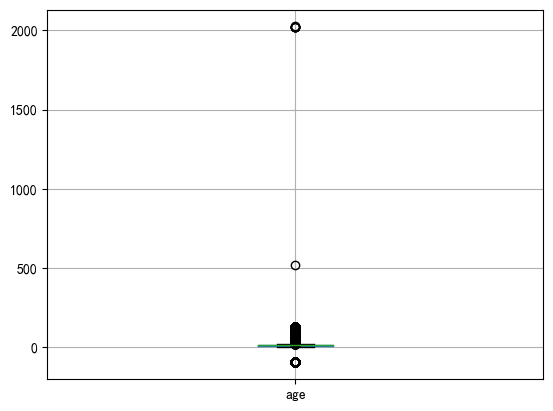

In [5]:
buyers_data.boxplot(column=['age'])

In [6]:
#排除掉年龄有异常的用户
buyers_data=buyers_data[buyers_data.age>0]
buyers_data=buyers_data[buyers_data.age<20]
buyers_data_old=buyers_data_old[buyers_data_old.age>0]
buyers_data_old=buyers_data_old[buyers_data_old.age<20]


In [7]:
#查看有没有缺失值
buyers_data.isnull().sum()
#没有缺失值

stat_date      0
buyer_id       0
last_caller    0
age            0
good_name      0
order_price    0
app_id         0
dtype: int64

In [8]:
#对年龄做分箱
buyers_data['age_cut']=pd.cut(buyers_data['age'],bins=[0,3,6,10,13,20])
buyers_data_old['age_cut']=pd.cut(buyers_data_old['age'],bins=[0,3,6,10,13,20])
# .astype('str')

In [9]:
#做数据透视表
now_table=buyers_data.pivot_table(values='order_price',index='age_cut',aggfunc=['sum','count'])
old_table=buyers_data_old.pivot_table(values='order_price',index='age_cut',aggfunc=['sum','count'])
#计算同比变化
now_table=now_table.sort_index(ascending=True)
old_table=old_table.sort_index(ascending=True)

now_table.index=now_table.index.map(str)
old_table.index=old_table.index.map(str)
round((now_table-old_table)/old_table*100,2)
# print(now_table.index)

,sum,count
,order_price,order_price
age_cut,,
"(0, 3]",-15.16628792213020235214882437,-31.20
"(3, 6]",-11.44995909993690251678211134,-13.49
"(6, 10]",2.792658067806503580861640638,-23.86
"(10, 13]",-13.63743771666954075287738019,-25.63
"(13, 20]",-36.16787020663889858052459812,-36.86


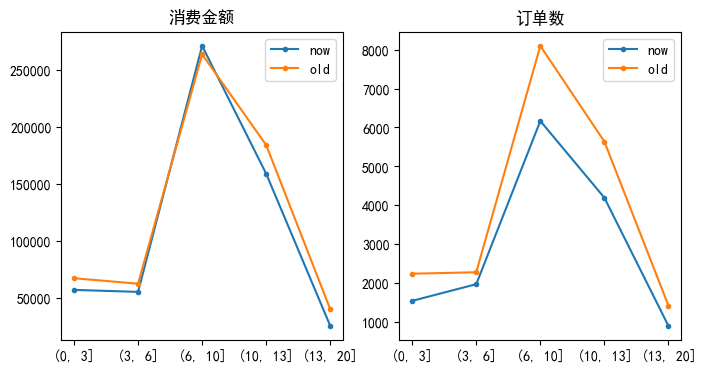

In [73]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(8,4))
i=0
for col in ['sum','count']:
    ax[i].plot(now_table[col],label='now',marker='.')
    ax[i].plot(old_table[col],label='old',marker='.')
    ax[i].legend()
    i+=1

ax[0].set_title('消费金额')
ax[1].set_title('订单数')
plt.show()

##### 这样看结果的话，今年和去年按年龄段比较，消费订单区别不大，但是消费金额差了不少

In [12]:
#对商品金额做分箱，看哪一个价格阶段的订单导致销售额少了
buyers_data['order_cut']=pd.cut(buyers_data['order_price'],bins=[0,10,30,70,100,200,300,np.inf])
buyers_data_old['order_cut']=pd.cut(buyers_data_old['order_price'],bins=[0,10,30,70,100,200,300,np.inf])
#分箱后做数据透视表
price_table_new=buyers_data.pivot_table(values='order_price',index='order_cut',aggfunc=['sum','count'])
price_table_old=buyers_data_old.pivot_table(values='order_price',index='order_cut',aggfunc=['sum','count'])
#把数据透视表的 index 改成字符串
price_table_new.index=price_table_new.index.map(str)
price_table_old.index=price_table_old.index.map(str)

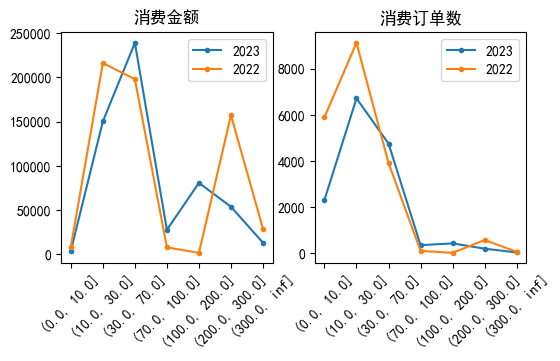

In [71]:
#画图
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(6,3))
i=0
for col in ['sum','count']:
    ax[i].plot(price_table_new[col],label='2023',marker='.')
    ax[i].plot(price_table_old[col],label='2022',marker='.')
    ax[i].legend()
    #设置横坐标的元素为歪的
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45)
    i+=1

ax[0].set_title('消费金额')
ax[1].set_title('消费订单数')
plt.show()

###### 由上图可知,2023年主要卖的是198的会员,2022年200+的订单卖的更多,所以目前要想办法提高,高单价商品的销售额